In [1]:
import torch.nn as nn
import torch
import utils
import train

device = torch.device("cuda:5")
torch.cuda.is_available(), device

(True, device(type='cuda', index=5))

In [9]:
adaptable_base_path = 'saved_models/AdaptableResNetCifar_2/'
#normal_base_path = 'saved_models/ResNetCifar/'
dist_base_path = 'saved_models/AdaptableDistResNetCifar_1/'


adaptable_model_path = adaptable_base_path + 'model'
#normal_model_path = normal_base_path + 'model'
dist_model_path = dist_base_path + 'model'

In [10]:
depth = 56
num_classes = 10
adaptable_net = utils.load_model(adaptable_model_path, depth, num_classes, device)
#normal_net = utils.load_model(normal_model_path, depth, num_classes, device)
dist_net = utils.load_model(dist_model_path, depth, num_classes, device)

Create ResNet-56 for 
Create ResNet-56 for 


In [11]:
model_fractions = utils.get_model_fractions(dist_net)
for fr in model_fractions:
    print(f'{fr:.3f}', end = ' ')

0.001 0.007 0.012 0.018 0.023 0.029 0.034 0.040 0.045 0.051 0.067 0.089 0.110 0.132 0.154 0.176 0.198 0.219 0.241 0.306 0.393 0.480 0.566 0.653 0.740 0.827 0.913 1.000 

In [12]:
batch_size = 64
val_size = 2000
train_size = 48000
_, __, testloader = utils.get_CIFAR10(batch_size, val_size, train_size)

In [14]:
def get_accuracies(net, dloader, criterion, device):

    accuracies = []

    net.reconfigure(1.)
    active_blocks = net.active_blocks

    for num_blocks in range(active_blocks + 1):
        print(f"Progress: {num_blocks}/{active_blocks}", end = '\r')

        net.reconfigure_blocks(num_blocks)
        loss, accuracy = train.loss_and_accuracy(net, dloader, criterion, device)
        accuracies.append(accuracy)
        
    print('')
    return accuracies

criterion = nn.CrossEntropyLoss()
adaptable_accuracies = get_accuracies(adaptable_net, testloader, criterion, device)
#normal_accuracies = get_accuracies(normal_net, testloader, criterion, device)
dist_accuracies = get_accuracies(dist_net, testloader, criterion, device)

Progress: 27/27
Progress: 27/27


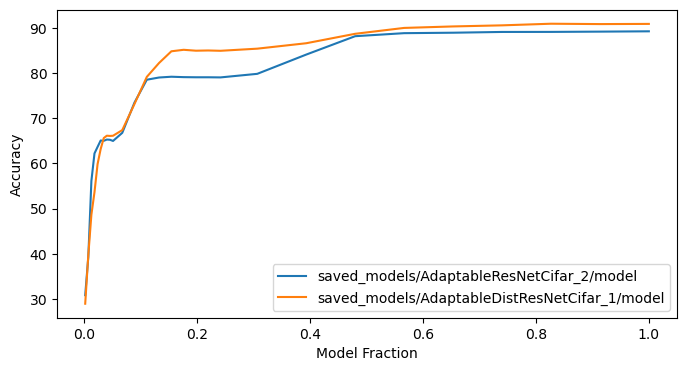

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(model_fractions, adaptable_accuracies, label = adaptable_model_path)
#plt.plot(model_fractions, normal_accuracies, label = normal_model_path)
plt.plot(model_fractions, dist_accuracies, label = dist_model_path)
plt.ylabel('Accuracy')
plt.xlabel('Model Fraction')

plt.legend()

In [18]:
adaptable_accuracies

[30.83,
 39.25,
 56.11,
 62.2,
 63.64,
 65.06,
 64.99,
 65.27,
 65.22,
 64.96,
 66.75,
 73.48,
 78.51,
 79.0,
 79.17,
 79.08,
 79.05,
 79.05,
 79.02,
 79.81,
 84.07,
 88.14,
 88.81,
 88.91,
 89.08,
 89.09,
 89.15,
 89.22]

In [9]:
results_adaptable = dict()
results_normal = dict()

results_adaptable['model_fractions'] = model_fractions
results_normal['model_fractions'] = model_fractions

results_adaptable['accuracy'] = adaptable_accuracies
results_normal['accuracy'] = normal_accuracies

In [10]:
import pickle5 as pickle

with open(adaptable_base_path + 'results.pkl', 'wb') as f:
    pickle.dump(results_adaptable, f, pickle.HIGHEST_PROTOCOL)

with open(normal_base_path + 'results.pkl', 'wb') as f:
    pickle.dump(results_normal, f, pickle.HIGHEST_PROTOCOL)